### Imports

In [83]:
import pandas as pd
import numpy as np

import re
import string

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os

from datetime import datetime

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer 
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
import nltk

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import preprocessing

from yellowbrick.cluster import KElbowVisualizer

from textblob import TextBlob

In [84]:
pd.set_option('max_colwidth', 800)

### Functions

In [85]:
def clean_up(s):
    words = s.split()
    words = [w.lower() for w in words if not w.startswith('http://')]
    words = re.findall('[^\d\W]+', ' '.join(words))
    return ' '.join(words)

def replace_urls(s, replacement=None):
    replacement = '<-URL->' if replacement is None else replacement
    pattern = re.compile('(https?://)?(\w*[.]\w+)+([/?=&]+\w+)*')
    return re.sub(pattern, replacement, s)

def tokenize(s):
    return word_tokenize(s)

def stem_and_lemmatize(l):
    l = ' '.join(l)
    stem = PorterStemmer().stem(l)
    lemm = WordNetLemmatizer().lemmatize(stem)
    return lemm

def remove_stopwords(l):
    languages = ['english',
             'spanish',
             'portuguese',
             'german',
             'french',
             'italian',
             'turkish'
            ]
    stop_words = stopwords.words(languages)
    return [i for i in l.split() if i not in stop_words]

def get_pm(row):
    pms = []
    text = row["text"].lower()
    if "boris" in text or "johnson" in text:
        pms.append("boris")
    elif "theresa" in text:
        pms.append("may")
    else:
        pms.append("none") 
    return ",".join(pms)

def sentiment_nlkt(text):
    sid = SentimentIntensityAnalyzer()
    polarity_scores = sid.polarity_scores(text)
    return 'negative' if polarity_scores['negative'] > polarity_scores['positive'] else 'positive'

def sentiment_textblob(text):
    analysis = TextBlob(text)
    return 'positive' if analysis.sentiment.polarity >= 0 else 'negative'

### Data

In [86]:
path = r'/Users/ironhack/Documents/GitHub/IronHack/W9FinalProject/final-project/your-project/tweets/' # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))
li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195000 entries, 0 to 194999
Data columns (total 15 columns):
username          195000 non-null object
to                98790 non-null object
text              194879 non-null object
retweets          195000 non-null int64
favorites         195000 non-null int64
replies           195000 non-null int64
id                195000 non-null int64
permalink         195000 non-null object
author_id         195000 non-null int64
date              195000 non-null object
formatted_date    195000 non-null object
hashtags          58429 non-null object
mentions          26404 non-null object
geo               0 non-null float64
urls              78250 non-null object
dtypes: float64(1), int64(5), object(9)
memory usage: 22.3+ MB


In [88]:
df.isna().sum()*100/len(df)

username            0.000000
to                 49.338462
text                0.062051
retweets            0.000000
favorites           0.000000
replies             0.000000
id                  0.000000
permalink           0.000000
author_id           0.000000
date                0.000000
formatted_date      0.000000
hashtags           70.036410
mentions           86.459487
geo               100.000000
urls               59.871795
dtype: float64

In [89]:
df.columns

Index(['username', 'to', 'text', 'retweets', 'favorites', 'replies', 'id',
       'permalink', 'author_id', 'date', 'formatted_date', 'hashtags',
       'mentions', 'geo', 'urls'],
      dtype='object')

In [90]:
df = df[['date','id', 'username', 'text']]

In [91]:
df.head()

,date,id,username,text
0,2019-03-12 23:59:59+00:00,1105619479478845441,El_7usseny,طب سريعاً كدا فيه غفلة من رجال الأمن أحب أتكلم شويه عن الـBrexit اللي هو انفصال المملكة المتحدة UK عن الاتحاد الأوروبي في ثريد صغير
1,2019-03-12 23:59:59+00:00,1105619476047953928,michael_b28,"@heuteshow ist das eigentlich richtig, dass der simulierte Angriff auf den EU Luftraum gestern Abend durch TUIfly mit #737MAX8 eine Aktionskunst zur Verhinderung des #Brexit war?"
2,2019-03-12 23:59:57+00:00,1105619470641446912,repnews,"Listen to this. What is Britain's ""fundamental interest"" in Ireland? If they answer that first, then they can figure out the border, then they can figure out Brexit."
3,2019-03-12 23:59:54+00:00,1105619456565395458,Lusa_noticias,Portugal prepara-se para cenário do 'Brexit' sem acordo que é “hoje mais possível” - MNE - https://www.lusa.pt/article/25807673
4,2019-03-12 23:59:54+00:00,1105619455739158529,themarketsniper,"Parliament’s rejection of Mrs. May’s deal shifts the focus to a vote scheduled for Wednesday on whether to oppose leaving without a deal - WATCH TOMORROW'S BETRAYAL OF REAL BREXIT, AS MAJORITY VOTE AGAINST NO DEAL EXIT. 99% CERTAIN OF IT. @TheResetSniper @DollarVigilante"


In [92]:
df.dropna(inplace=True)

In [93]:
df.dtypes

date        object
id           int64
username    object
text        object
dtype: object

### Fixing time type column

In [94]:
df['date'] = pd.to_datetime(df['date'])
df['date'] = [d.date() for d in df['date']]

### Creating column for Theresa May/Boris Jonhson

In [95]:
df["pm"] = df.apply(get_pm,axis=1)

In [96]:
le = preprocessing.LabelEncoder()
df["pm_label"] = le.fit_transform(df.pm.values)

In [97]:
df["pm"].value_counts()

none     180281
boris      7357
may        7241
Name: pm, dtype: int64

In [17]:
may_df = df[df['pm'] == 'may']
boris_df = df[df['pm'] == 'boris']
df_mb = may_df.append(boris_df)

In [98]:
boris_df.shape

(7357, 7)

### Cleaning the tweets

In [99]:
df['text_processed_vector'] = df['text'].apply(replace_urls)

In [101]:
df['text_processed'] = df['text'].apply(clean_up).apply(tokenize).apply(stem_and_lemmatize)\
                       .apply(remove_stopwords)

### Checking top words

Text(0.5, 1.0, 'Most Frequently Occuring Words - Top 50')

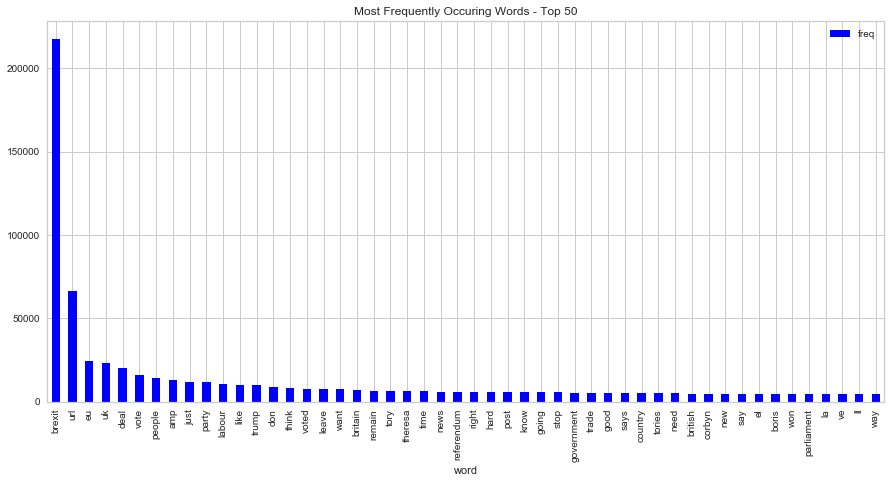

In [104]:
cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df['text_processed_vector'])

sum_words = words.sum(axis=0)

words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)

frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(50).plot(x='word', y='freq', kind='bar', figsize=(15, 7), color = 'blue')
plt.title("Most Frequently Occuring Words - Top 50")

## K-means

### Checking optimal number of clusters

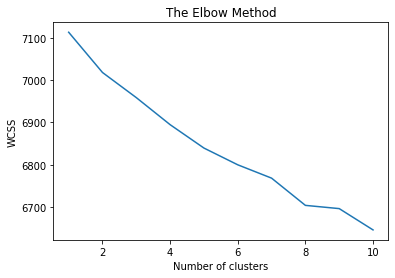

In [50]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i,init='k-means++',n_init=10,random_state=0)
    kmeans.fit(X3)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,17))
visualizer.fit(X3)
visualizer.poof()

### Preparing & Implementing K-Means

In [79]:
# vectorizing
tf_idf_vect = CountVectorizer(analyzer='word',ngram_range=(1,1),stop_words='english', min_df = 0.0001)
tf_idf_vect.fit(df['text'])
desc_matrix = tf_idf_vect.transform(df["text"])
print('{} Number of tweets has {} words'.format(countVector.shape[0], countVector.shape[1]))

In [123]:
# implementing kmeans
km = KMeans(n_clusters = 3, n_init = 10, n_jobs = -1)
km.fit(desc_matrix)
clusters = km.labels_.tolist()

In [124]:
df['labels'] = clusters

In [128]:
df

,date,id,username,text,pm,pm_label,text_processed_vector,text_processed,labels
0,2019-03-12,1105619479478845441,El_7usseny,طب سريعاً كدا فيه غفلة من رجال الأمن أحب أتكلم شويه عن الـBrexit اللي هو انفصال المملكة المتحدة UK عن الاتحاد الأوروبي في ثريد صغير,none,2,طب سريعاً كدا فيه غفلة من رجال الأمن أحب أتكلم شويه عن الـBrexit اللي هو انفصال المملكة المتحدة UK عن الاتحاد الأوروبي في ثريد صغير,"[طب, سريعا, كدا, فيه, غفلة, من, رجال, الأمن, أحب, أتكلم, شويه, عن, الـbrexit, اللي, هو, انفصال, المملكة, المتحدة, uk, عن, الاتحاد, الأوروبي, في, ثريد, صغير]",0
1,2019-03-12,1105619476047953928,michael_b28,"@heuteshow ist das eigentlich richtig, dass der simulierte Angriff auf den EU Luftraum gestern Abend durch TUIfly mit #737MAX8 eine Aktionskunst zur Verhinderung des #Brexit war?",none,2,"@heuteshow ist das eigentlich richtig, dass der simulierte Angriff auf den EU Luftraum gestern Abend durch TUIfly mit #737MAX8 eine Aktionskunst zur Verhinderung des #Brexit war?","[heuteshow, eigentlich, richtig, simulierte, angriff, luftraum, gestern, abend, tuifly, max, aktionskunst, verhinderung, brexit]",0
2,2019-03-12,1105619470641446912,repnews,"Listen to this. What is Britain's ""fundamental interest"" in Ireland? If they answer that first, then they can figure out the border, then they can figure out Brexit.",none,2,"Listen to this. What is Britain's ""fundamental interest"" in Ireland? If they answer that first, then they can figure out the border, then they can figure out Brexit.","[listen, britain, fundamental, interest, ireland, answer, first, figure, border, figure, brexit]",0
3,2019-03-12,1105619456565395458,Lusa_noticias,Portugal prepara-se para cenário do 'Brexit' sem acordo que é “hoje mais possível” - MNE - https://www.lusa.pt/article/25807673,none,2,Portugal prepara-se para cenário do 'Brexit' sem acordo que é “hoje mais possível” - MNE - <-URL->,"[portugal, prepara, cenário, brexit, acordo, hoje, possível, mne, https, www, lusa, pt, articl]",1
4,2019-03-12,1105619455739158529,themarketsniper,"Parliament’s rejection of Mrs. May’s deal shifts the focus to a vote scheduled for Wednesday on whether to oppose leaving without a deal - WATCH TOMORROW'S BETRAYAL OF REAL BREXIT, AS MAJORITY VOTE AGAINST NO DEAL EXIT. 99% CERTAIN OF IT. @TheResetSniper @DollarVigilante",none,2,"Parliament’s rejection of Mrs. May’s deal shifts the focus to a vote scheduled for Wednesday on whether to oppose leaving without a deal - WATCH TOMORROW'S BETRAYAL OF REAL BREXIT, AS MAJORITY VOTE AGAINST NO DEAL EXIT. 99% CERTAIN OF IT. @TheResetSniper @DollarVigilante","[parliament, rejection, mrs, may, deal, shifts, focus, vote, scheduled, wednesday, whether, oppose, leaving, without, deal, watch, tomorrow, betrayal, real, brexit, majority, vote, deal, exit, certain, theresetsniper, dollarvigilant]",0
...,...,...,...,...,...,...,...,...,...
194995,2020-02-12,1227667450742833153,RevistaEstePais,"Bruce Swancey escribe sobre el decadente imperio #británico: su literatura, el #Brexit y su relación con la #UniónEuropea",none,2,"Bruce Swancey escribe sobre el decadente imperio #británico: su literatura, el #Brexit y su relación con la #UniónEuropea","[bruce, swancey, escribe, decadente, imperio, británico, literatura, brexit, relación, unióneuropea]",0
194996,2020-02-12,1227667447395864577,Will83064416,"I didn’t vote mate, I support my club no matter what, and also let’s end this on a statistic. 54% voted for parties who wanted another referendum, I notice how you turn a blind eye to that.",none,2,"I didn’t vote mate, I support my club no matter what, and also let’s end this on a statistic. 54% voted for parties who wanted another referendum, I notice how you turn a blind eye to that.","[vote, mate, support, club, matter, let, end, statistic, voted, parties, wanted, another, referendum, notice, turn, blind, eye]",0
194997,2020-02-12,1227667425610563584,movarsi,"Twelve Days After Brexit, U.K. Falls Foul of EU Rules",none,2,"Twelve Days After Brexit, <-URL->. Falls Foul of

In [129]:
sns.scatterplot(x="pm_label", y="username", hue='labels', data=df)

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x11bc957a0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x11bf0cf80> (for post_execute):


KeyboardInterrupt: 

### Checking results

#### 3 iterations

In [122]:
df[df['pm'] == 'may']['labels'].value_counts()

1    4651
2    1357
0    1233
Name: labels, dtype: int64

In [121]:
df[df['pm'] == 'boris']['labels'].value_counts()

1    6068
2     700
0     589
Name: labels, dtype: int64

#### 10 iterations

In [125]:
df[df['pm'] == 'may']['labels'].value_counts()

0    4751
1    1338
2    1152
Name: labels, dtype: int64

In [126]:
df[df['pm'] == 'boris']['labels'].value_counts()

0    6206
1     681
2     470
Name: labels, dtype: int64

## Evaluating model

In [ ]:
preds = cluster.fit_predict(features)
centers = cluster.cluster_centers_

score = silhouette_score (features, preds, metric='euclidean')
print (f"For n_clusters = {n_clusters}, silhouette score is {score})")

## try to plot to see what it looks like

## Sentiment Analysis

In [130]:
#with nlkt sentiment analysys
sentiments_nlkt = df['processed_text'].apply(lambda tweet: sentiment_nlkt(tweet))
pd.DataFrame(sentiments_nlkt.value_counts())

KeyError: 'processed_text'

In [ ]:
#with textblob sentiment analysys
sentiments_textblob = df['processed_text'].apply(lambda tweet: sentiment_textblob(tweet))
pd.DataFrame(sentiments_textblob.value_counts())